# Example: application rSVD Kratos to a free beam

02/02/2021

I apply the Kratos rSVD algorithm to an output file from a small dynamic simulation carried out by RamSeries. 

The model is a free cantilever beam with a dynamic sinusoidal pressure load.

freq = 0.1Hz
Load = -1000N/m2
dt = 0.1s
time_steps = 800

### Import libraries

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

### Read output file of Compass: computation of the snapshot matrix

I have developed a function to read the output file of RamSeries and compute the snapshot matrix

In [8]:
def create_snapshotmatrix_from_file(path_file):
    """ Compute snapshot matrix from output ascii file of Compass."""

    # Read lines and close file
    f = open(path_file, 'r')
    lines = f.readlines()
    f.close()

    # Create list of time steps
    deg_freedom = 3  # displ_x, displ_y, displ_z
    t = []
    values_list = []

    for i_line, line in enumerate(lines):
        if 'Result "Displacements (m)"' in line:
            t.append(float(line.split()[4]))
            i_jump = 3  # Lines to jump between header and values.
            values = []

            while lines[i_line + i_jump][0].isdigit():
                values.append(lines[i_line + i_jump])
                i_jump = i_jump + 1

            values_list.append(values)

    nb_nodes = len(values_list[0])
    nb_time_steps = len(values_list)

    # Create snapshot matrix
    snapshot_mtx = np.empty(shape=(nb_nodes * deg_freedom, nb_time_steps))

    for i_time_step in np.arange(nb_time_steps):
        values_to_list = []

        # Convert string to float values (displ_x, displ_y, displ_z)
        for i_node in np.arange(nb_nodes):
            values_to_list.append(float(values_list[i_time_step][i_node].split()[1]))
            values_to_list.append(float(values_list[i_time_step][i_node].split()[2]))
            values_to_list.append(float(values_list[i_time_step][i_node].split()[3]))

        snapshot_mtx[:, i_time_step] = np.array(values_to_list)

    return snapshot_mtx

 We define the path of the output file

In [12]:
path_root = Path("/home/usuari/Documentos/CIMNE/bibliografia/model_order_reduction/python_scripts")
name_file = "beam_simple_f01hz_dt01_tsteps800_msh005.flavia.res"
path_file = path_root / name_file

Computation of the snapshot matrix

In [13]:
snapshot_matrix = create_snapshotmatrix_from_file(path_file)

In [19]:
degrees_freedom = 3 
print(f"number of nodes = {snapshot_matrix.shape[0] // degrees_freedom}")
print(f"number of time steps = {snapshot_matrix.shape[1]}")

number of nodes = 201
number of time steps = 800


### Plot the displacements for different nodes

I have implemented a function to plot the displacements as function of time at different nodes

In [20]:
def plot_displacements_time_per_node(snapshot_matrix, deg_freedom=3, nb_nodes_decimation=20):
    """
    Plot displacements as function of time per node.
    Only implemented for the output file: 
    beam_simple_f01hz_dt01_tsteps800_msh005.flavia.res
    """

    # Create parameters figure
    fig, ax = plt.subplots()
    ax.set_xlabel("t(s)")
    ax.set_ylabel("u (m)")

    # Create array time
    times = np.arange(0, 80, 0.1)

    # Create array indices
    array_indices = np.arange(1, 201, deg_freedom * nb_nodes_decimation)

    # Plot each node
    for ii, node in enumerate(array_indices):
        ax.plot(times, snapshot_matrix[node], "-o", label=f"Node {node}")

    plt.legend()

    return fig, ax

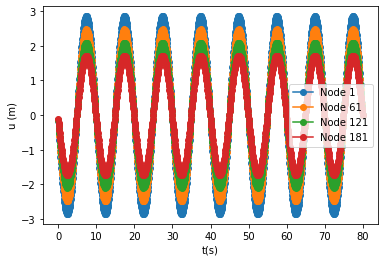

In [21]:
fig, ax = plot_displacements_time_per_node(snapshot_matrix)

Node 1 is the node at the free side of the beam. 
Node 181 is the node close to the constrained side.

The frequency of the displacement is the same as the frequency of the sinusoidal pressure load. 

### Apply Kratos rSVD to the output file

In [24]:
from KratosMultiphysics.RomApplication.randomized_singular_value_decomposition import RandomizedSingularValueDecomposition

In [25]:
# Compute randomized Singular Value Decomposition of the snapshot matrix
tolerance = 1e-6
u, s, _, _ = RandomizedSingularValueDecomposition().Calculate(snapshot_matrix, tolerance)

iter =  1  nC =  6.82709976723093e-07  dR =  4.0  R =  4
reorthogonalizing
iter =  2  nC =  5.08664171651301e-07  dR =  31.0  R =  35
reorthogonalizing
iter =  3  nC =  5.216504080987838e-09  dR =  151.0  R =  186
reorthogonalizing
iter =  4  nC =  5.783243557758824e-14  dR =  151.0  R =  337


In [27]:
print(f"Number of modes = {u.shape[1]}")

Number of modes = 1


This mode corresponds to the frequency of the displacement.